# Example Notebook

This notebook will load some sample data from wind and create a compressibility scalogram.

In [ ]:
%reload_ext autoreload

## ========== ##
# Run the following code to install the Time-Series-Scalogram package
## ========== ##

# install some packages
# !pip install pyspedas
# !pip install pandas
# !pip install matplotlib

# install the Time-Series-Scalogram package
# !pip install Time-Series-Scalogram
# !pip install --upgrade Time-Series-Scalogram

In [4]:
# load the ts_scalogram module
from Time_Series_Scalogram import ts_scalogram

# load pyspedas
import pyspedas
from pytplot import tplot, get_data, time_string

# load pandas
import pandas as pd

# load numpy
import numpy as np

## Download Data

In [5]:
# download some wind data
# case 375 from https://wind.nasa.gov/ICME_catalog/ICME_catalog_viewer.php

t0 = pd.Timestamp('2018-06-06 11:23:00')
t1 = pd.Timestamp('2018-06-07 08:29:00')
dt = t1 - t0

# load data from a larger window
t00 = t0 - dt
t11 = t1 + dt


mfi_vars = pyspedas.wind.mfi(trange=[t00.strftime('%Y-%m-%d %H:%M:%S'), t11.strftime('%Y-%m-%d %H:%M:%S')], datatype='h4-rtn')
mag_mfi = get_data('BRTN')
index = [pd.Timestamp(x) for x in time_string(mag_mfi.times)]
df_mfi = pd.DataFrame(mag_mfi.y, index=index, columns= ['Bx', 'By', 'Bz'])
df_mfi['Btot'] = np.sqrt(df_mfi['Bx']**2 + df_mfi['By']**2 + df_mfi['Bz']**2)
df_mfi.sort_index(inplace=True)

03-Nov-24 22:24:19: File is current: wind_data/wind_masters/wi_h4-rtn_mfi_00000000_v01.cdf
03-Nov-24 22:24:19: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h4-rtn/2018/
03-Nov-24 22:24:19: File is current: wind_data/mfi/mfi_h4-rtn/2018/wi_h4-rtn_mfi_20180605_v05.cdf
03-Nov-24 22:24:20: File is current: wind_data/mfi/mfi_h4-rtn/2018/wi_h4-rtn_mfi_20180606_v05.cdf
03-Nov-24 22:24:20: File is current: wind_data/mfi/mfi_h4-rtn/2018/wi_h4-rtn_mfi_20180607_v05.cdf
03-Nov-24 22:24:21: File is current: wind_data/mfi/mfi_h4-rtn/2018/wi_h4-rtn_mfi_20180608_v05.cdf


## Process Data

In [6]:
# smooth |B|
Btot = df_mfi['Btot'] # load magnetic magnitude
Btot_smooth = Btot.apply(np.log10).rolling('5min').median().apply(lambda x: 10**x) # smooth the data with 5 minute log median
Btot_normed = Btot/Btot_smooth # normalize the time series

# calculate the windows
upper_bound = ((index[-1] - index[0])/2).ceil('1H') # upper bound is half of the time range
t_step = np.timedelta64(5, 'm') # a suitable time step
yrange = [np.timedelta64(0,'m'), upper_bound] # range of the y axis
num_wins = 10000
win_step = t_step*2
win0 = t_step * 2 # should be nX of t_step, where n is an integer, here I use 2
wins = np.array(np.arange(num_wins)*win_step+win0, dtype = np.timedelta64) # list of "raw" windows
ind = (wins >= yrange[0]) & (wins <= yrange[1]) # select the windows within the yrange
wins = wins[ind] # final windows

03-Nov-24 22:25:28: /var/folders/g1/jbj1s_4x7wn1f67ffjt2_thm0000gn/T/ipykernel_78172/2715919445.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  upper_bound = ((index[-1] - index[0])/2).ceil('1H') # upper bound is half of the time range



## Calculate the Scalogram

Here the default pixel color function is compressibility counter:

```python
def compressbility(x):
    try:

        scan = {
            'value': np.sum(np.abs(np.log10(x)) > 0.02)/len(x),
        }

    except:
        scan = {
            'value': np.nan
        }

    return scan
```

you can define your own pixel color function by writing your own function. It should be a .py file and the name of the function should be func. For example:
```python
import numpy as np
def func(x):
    """
    This is a pixel color function. 
    Input: x
        the windowed time series
    Output:
        ideally a dictionary containing everything you want out of x
    """

    # for example returning mean and std
    scan = {
        'mean': np.nanmean(x),
        'std': np.nanstd(x)
    }
    return scan
```

Then provide the **absolute** path of the function in string and pass it to the module via pixel_func_path

In [ ]:
import os
savpath = "./temp/"
os.makedirs(savpath, exist_ok=True)

scans, settings = ts_scalogram.TimeSeriesScalogram(
    Btot_normed,
    wins,
    t_step,
    chunksize = 500,
    Ncores = 16,
    savpath = savpath
    pixel_func_path = None
)

t step: 5 minutes
length of xgrid: 1152, tstep=0 days 00:05:00, range: 2018-06-05 00:01:00 -> 2018-06-08 23:56:00
--------------------------------------------
Step Win Ratio: 0.01
--------------------------------------------

10 minutes 5 minutes 0.5 1 1151
110 minutes 5 minutes 0.045454545454545456 1 1151
210 minutes 5 minutes 0.023809523809523808 1 1151
310 minutes 5 minutes 0.016129032258064516 1 1151
410 minutes 5 minutes 0.012195121951219513 1 1151
510 minutes 5 minutes 0.00980392156862745 1.0 1151
610 minutes 5 minutes 0.00819672131147541 1.0 1151
710 minutes 5 minutes 0.007042253521126761 1.0 1151
810 minutes 5 minutes 0.006172839506172839 1.0 1151
910 minutes 5 minutes 0.005494505494505495 1.0 1151
1010 minutes 10 minutes 0.0049504950495049506 2.0 575
1110 minutes 10 minutes 0.0045045045045045045 2.0 575
1210 minutes 10 minutes 0.004132231404958678 2.0 575
1310 minutes 10 minutes 0.003816793893129771 2.0 575
1410 minutes 10 minutes 0.0035460992907801418 2.0 575
1510 minutes 15 

100%|██████████| 185358/185358 [00:39<00:00, 4666.01it/s]


Saved at: temp/df_results_000.pkl



## Process the results

In [8]:
df_scans = pd.read_pickle('./temp/df_results_000.pkl')
settings = pd.read_pickle('./temp/settings.pkl')

# df_scans['value'].hist(bins = 100, density = True)

xgrid, xinds = settings['xgrid'], settings['xinds']

# Assuming df_scans, xgrid, and wins are already loaded
win_grid = np.arange(pd.Timedelta(0, 'm'), np.max(wins), wins[1] - wins[0])
array_2d = np.full((len(xgrid), len(win_grid)), np.nan)


if os.path.exists('./temp/df_interpolated.pkl'):
    df_interpolated = pd.read_pickle('./temp/df_interpolated.pkl')
else:
    for index, row in df_scans.iterrows():
        tmid = row['tmid']
        win = row['win']
        value = row['value']

        try:
            tmid_idx = np.where(xgrid == tmid)[0][0]
            win_idx = np.where(win_grid == win)[0][0]
            array_2d[tmid_idx, win_idx] = value
        except IndexError:
            pass

    df_filled = pd.DataFrame(array_2d, index=xgrid, columns=win_grid)

    # Interpolate missing values using the nearest method
    df_interpolated = df_filled.interpolate(method='nearest', axis=1, limit_direction='both')
    df_interpolated.to_pickle('./temp/df_interpolated.pkl')

## Visualize the Scalogram

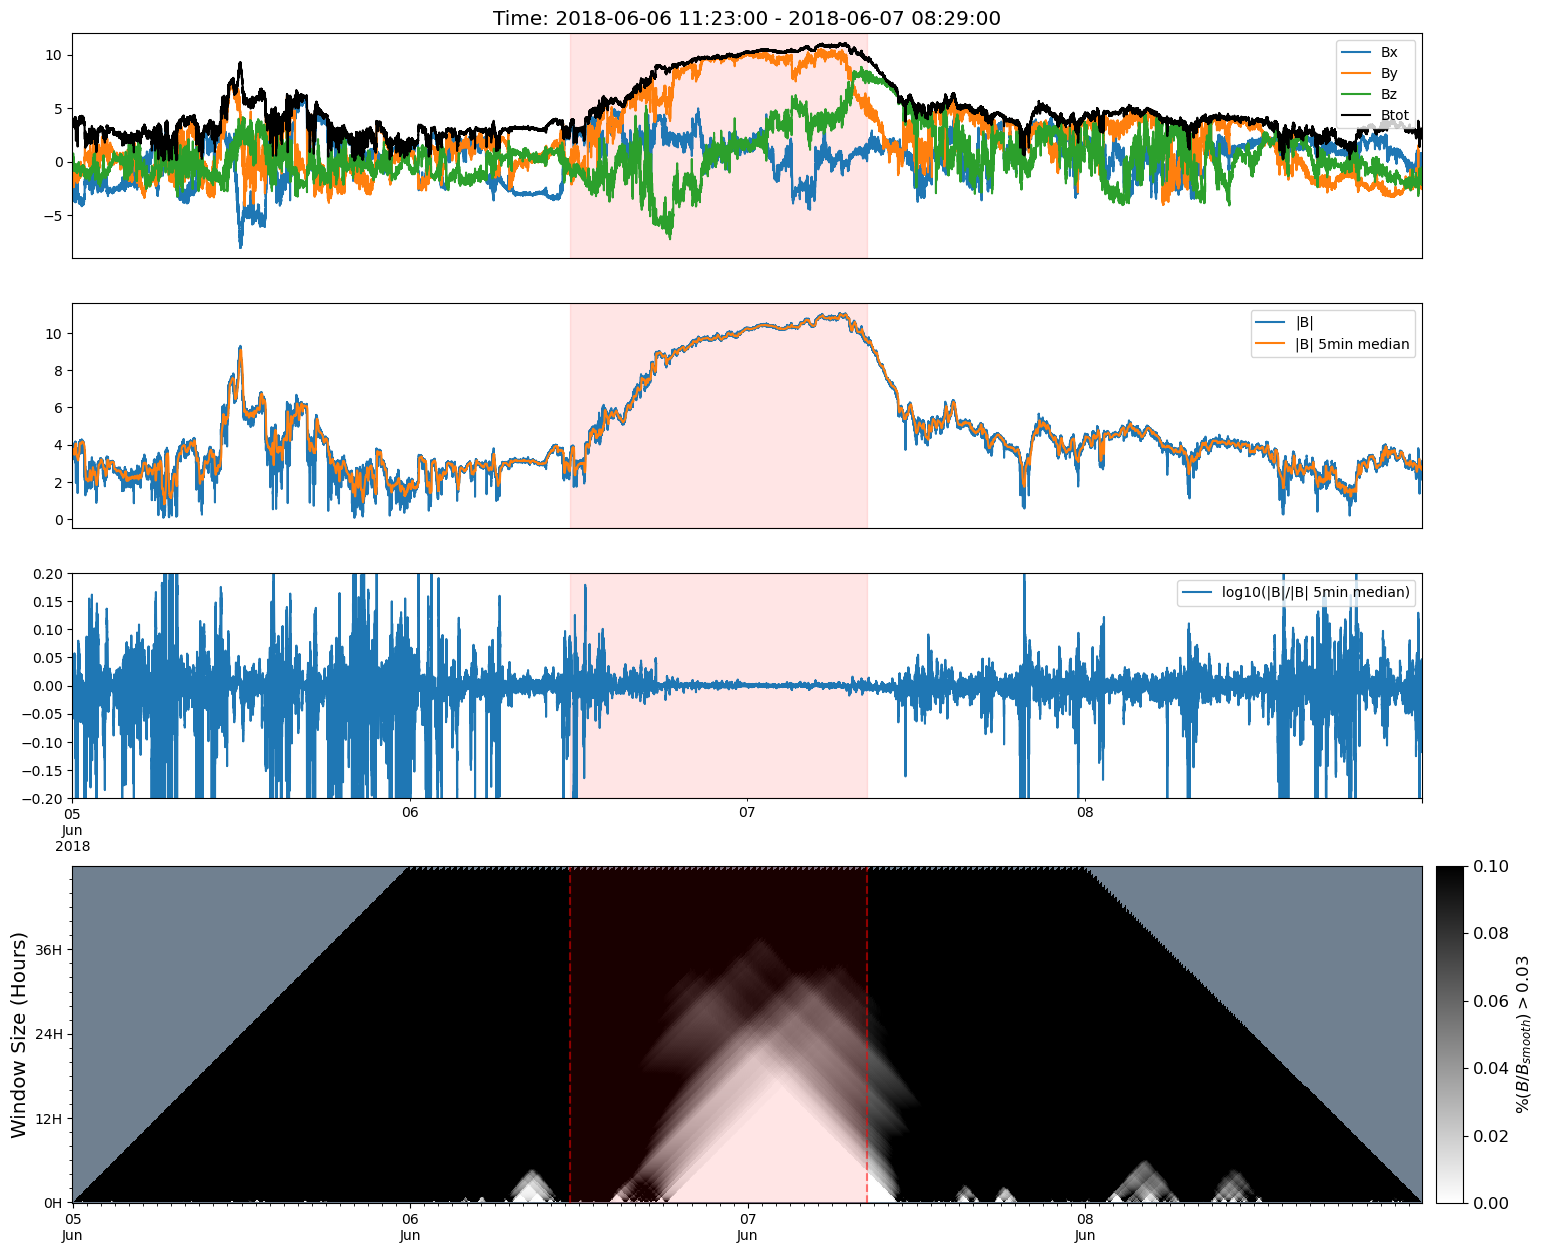

In [9]:
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt  # Ensure you have imported pyplot

array_2d_filled = df_interpolated.values

fig, axes = plt.subplots(3,1, figsize = (15,9))
fig.subplots_adjust(top = 0.95, bottom = 0.1, left=0.05, right = 0.95, wspace = 0.05)

plt.sca(axes[0])
plt.title("Time: %s - %s" %(t0, t1), fontsize = 'x-large')
df_mfi[['Bx', 'By', 'Bz', 'Btot']].resample('1s').mean().plot(style = ['C0', 'C1', 'C2', 'k'], ax =plt.gca())
# turn of x axis
plt.gca().xaxis.set_visible(False)
plt.legend(loc = 'upper right')

plt.sca(axes[1])
Btot = df_mfi['Btot'] # load magnetic magnitude
Btot_smooth = Btot.apply(np.log10).rolling('5min').median().apply(lambda x: 10**x)
Btot.resample('1s').mean().plot(label = '|B|')
Btot_smooth.resample('1s').mean().plot(label = '|B| 5min median')
plt.legend(loc = 'upper right')
# turn of x axis
plt.gca().xaxis.set_visible(False)

plt.sca(axes[2])
(Btot/Btot_smooth).resample('1s').mean().apply(np.log10).plot(label = 'log10(|B|/|B| 5min median)')
plt.ylim([-0.2, 0.2])
plt.legend(loc = 'upper right')

for ax in axes:
    plt.sca(ax)
    plt.axvspan(xmin = t0, xmax = t1, color = 'r', alpha = 0.1)
    try:
        plt.axvline(x = tmo, color = 'g', alpha = 0.5, linestyle = '--')
    except:
        pass


# plt.figure(figsize=(12, 3), dpi=150, layout = 'constrained')

# add one more axes 

position = axes[2].get_position()

# append one ax on the bottom
new_axis_position = [
    position.x0, position.y0 - position.height*1.8,
    position.width, position.height*1.5
]

# Add the new axis to the figure
new_ax = fig.add_axes(new_axis_position)

ax = new_ax

x_num = mdates.date2num(xgrid)
y = np.arange(0, len(win_grid), 1)
X, Y = np.meshgrid(x_num, y)

# Assuming data is your 2D JS divergence array
# data = np.log10(array_2d_filled.T)
data = array_2d_filled.T

# Create a colormap from white to black
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", ["white", "black"])

# Set color for NaN values
cmap.set_bad(color='slategray')

im = plt.pcolormesh(X, Y, data, cmap=cmap, vmin=0, vmax=0.1)
ax.set_aspect('auto')

# ===== Fixed y-ticks code starts here =====

# Convert win_grid from nanoseconds to hours
win_grid_hours = win_grid / np.timedelta64(1, 'h')

# Define the target intervals for major and minor ticks
major_tick_interval = 12  # Every 6 hours for major ticks
minor_tick_interval = 2  # Every hour for minor ticks

# Identify indices for each hour (minor ticks) and every 6 hours (major ticks)
major_indices = [np.argmin(np.abs(win_grid_hours - hour)) for hour in np.arange(0, max(win_grid_hours), major_tick_interval)]
minor_indices = [np.argmin(np.abs(win_grid_hours - hour)) for hour in np.arange(0, max(win_grid_hours), minor_tick_interval)]

# Generate labels for major ticks (6-hour intervals)
major_labels = [f"{int(win_grid_hours[idx])}H" for idx in major_indices]

# Set major ticks and their labels
ax.set_yticks(major_indices)
ax.set_yticklabels(major_labels)

# Set minor ticks without labels
ax.yaxis.set_minor_locator(ticker.FixedLocator(minor_indices))

# Set y-axis label
plt.ylabel("Window Size (Hours)", size='x-large')



# ===== Fixed y-ticks code ends here =====

cbar_ax = ax.inset_axes([1.01, 0.0, 0.02, 1.0])

plt.colorbar(mappable=im, cax=cbar_ax)
cbar_ax.tick_params(axis='both', which='major', labelsize='large')
cbar_ax.set_ylabel(r'$\%(B/B_{smooth})>0.03$', size='large')

# ===== Format the x-axis
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()      # every day
hours = mdates.HourLocator()

# Using abbreviated month name
months_fmt = mdates.DateFormatter('%d\n%b\n%Y')  # %b gives abbreviated month name
days_fmt = mdates.DateFormatter('%d\n%b')
hours_fmt = mdates.DateFormatter('')

ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(days_fmt)
ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_minor_formatter(hours_fmt)

# To display minor tick labels, must use the xaxis.set_tick_params
plt.tick_params(axis='x', which='minor', bottom=True, labelbottom=True)

# Setting rotation to 0
plt.xticks(rotation=0)
# =====

plt.axvspan(xmin = t0, xmax = t1, color = 'r', alpha = 0.1)
plt.axvline(x = t0, color = 'r', alpha = 0.5, linestyle = '--')
plt.axvline(x = t1, color = 'r', alpha = 0.5, linestyle = '--')


plt.show()  # Display the plot
# plt.close()
